In [1]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm
from scipy.integrate import odeint
from scipy.integrate import odeint

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


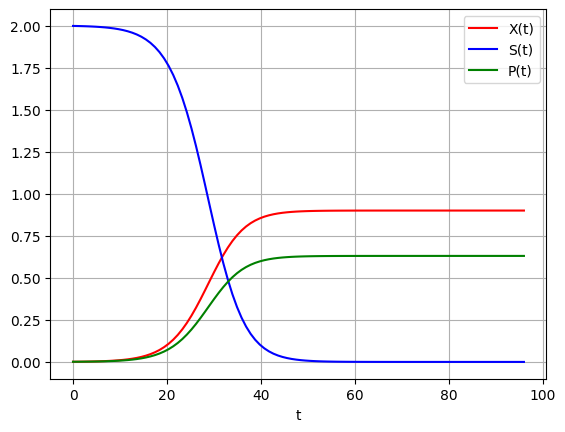

In [87]:
# Define the ODE system
def f_A(y, t):
    X = y[0]
    S = y[1]
    P = y[2]
    
    mu_max = 2
    Ks = 15
    Y_XS = 0.45
    a = 0.7
    
    mu = mu_max * S / (S + Ks)
    
    dydt = [mu * X, -1/Y_XS * mu * X, a * mu * X]
    
    return dydt

y0 = [0.001, 2, 0.001]  # Initial conditions
t = np.linspace(0, 96, 100)  # Time vector
sol = odeint(f_A, y0, t)

X = sol[:, 0]
S = sol[:, 1]
P = sol[:, 2]

# Plot the results
plt.plot(t, X, 'r', label='X(t)')
plt.plot(t, S, 'b', label='S(t)')
plt.plot(t, P, 'g', label='P(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid(True)
plt.show()

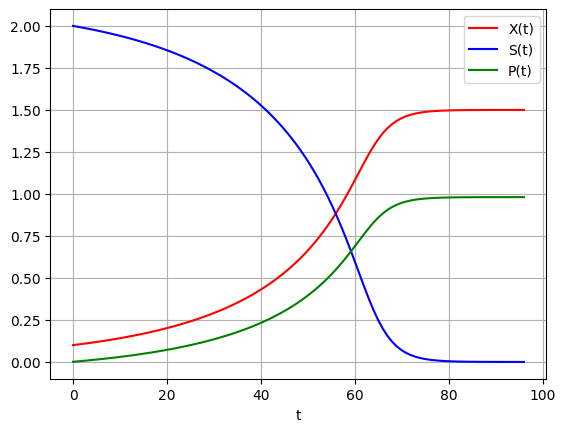

In [101]:
# Define the ODE system
def f_B(y, t):
    X = y[0]
    S = y[1]
    P = y[2]
    
    mu_max = 2
    Ks = 15
    Ki = 25
    
    Y_XS = 0.7
    a = 0.7
    
    mu = mu_max * S / (S + Ks + S**2 * Ki)
    
    dydt = [mu * X, -1/Y_XS * mu * X, a * mu * X]
    
    return dydt

y0 = [0.1, 2, 0.001]  # Initial conditions
t = np.linspace(0, 96, 100)  # Time vector
sol = odeint(f_B, y0, t)

X = sol[:, 0]
S = sol[:, 1]
P = sol[:, 2]

# Plot the results
plt.plot(t, X, 'r', label='X(t)')
plt.plot(t, S, 'b', label='S(t)')
plt.plot(t, P, 'g', label='P(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid(True)
plt.show()

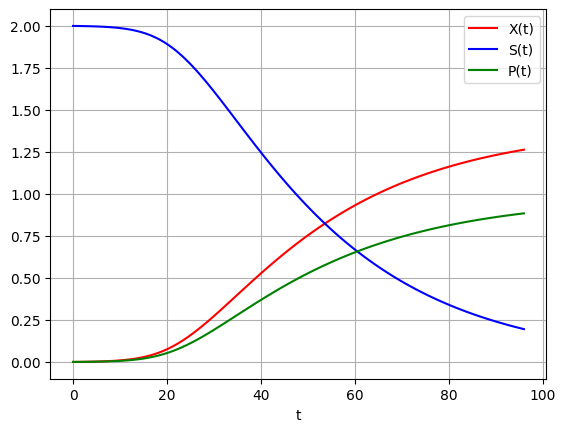

In [104]:
# Define the ODE system
def f_C(y, t):
    X = y[0]
    S = y[1]
    P = y[2]
    
    mu_max = 2
    Ks = 15
    Kp = 100
    Y_XS = 0.7
    a = 0.7
    
    mu = mu_max * S / (S + Ks + P * Kp)
    
    dydt = [mu * X, -1/Y_XS * mu * X, a * mu * X]
    
    return dydt

y0 = [0.001, 2, 0.001]  # Initial conditions
t = np.linspace(0, 96, 100)  # Time vector
sol = odeint(f_C, y0, t)

X = sol[:, 0]
S = sol[:, 1]
P = sol[:, 2]

# Plot the results
plt.plot(t, X, 'r', label='X(t)')
plt.plot(t, S, 'b', label='S(t)')
plt.plot(t, P, 'g', label='P(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid(True)
plt.show()

In [108]:
t = torch.tensor(t, dtype=torch.float32, device=DEVICE)
X_true = torch.tensor(X, dtype=torch.float32, device=DEVICE)
S_true = torch.tensor(S, dtype=torch.float32, device=DEVICE)
P_true = torch.tensor(P, dtype=torch.float32, device=DEVICE)


/tmp/ipykernel_112718/2844182606.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32, device=DEVICE)


In [109]:
def np_to_th(x):
    n_samples = len(x)
    return torch.from_numpy(x).to(torch.float).to(DEVICE).reshape(n_samples, -1)

class Net(nn.Module):
    def __init__(self, input_dim, output_dim, n_units=100, epochs=100, loss=nn.MSELoss(), \
        lr=1e-3, loss2=None, loss2_weight=0.1) -> None:
        
        super().__init__()
        self.epochs = epochs
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.n_units = n_units
        
        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
        )
        self.out = nn.Linear(self.n_units, output_dim)
        
    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)
        return out
        
    def fit(self, X, y):
        Xt = np_to_th(X)
        yt = np_to_th(y)
        
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        self.train()
        losses = []
        for ep in range(self.epochs):
            optimizer.zero_grad()
            outputs = self.forward(Xt)
            loss = self.loss(yt, outputs)
            if self.loss2:
                loss += self.loss2_weight + self.loss2_weight * self.loss2(self)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            if ep % 500 == 0:
                print(f'Epoch {ep}/{self.epochs}, Loss: {loss.item()}')
        return losses
    
    def predict(self, X):
        self.eval()
        out = self.forward(np_to_th(X))
        return out.detach().cpu().numpy()
    

class ParameterEstimation(Net):
    def __init__(self, input_dim, output_dim, n_units=100, epochs=100, loss=nn.MSELoss(), lr=0.001,\
        loss2=None, loss2_weight=0.1) -> None:
        super().__init__(input_dim, output_dim, n_units, epochs, loss, lr, loss2, loss2_weight)
        
        # dydt = [mu * X, -1/Y_XS * mu * X, a * mu * X]
        self.mu = nn.Parameter(data=torch.tensor([1.]))  
        self.Y_XS = nn.Parameter(data=torch.tensor([1.]))
        self.a = nn.Parameter(data=torch.tensor([1.]))
        